### Creating an image classifier able to find sneakers in instagram posts

The data comprises of few thousand images of sneakers collected using google images and instagram
and few thousand images of sneakers.    
Your goal is to use what you learned from previous examples and create a sneaker-not-sneaker binary classifier.

The task comprises of multiple sub-tasks that you need to do to build the classifier.

1. Create a dataset able to load data from new_meta_sneakers.csv
2. Create a fine tune binary classification architecture.
3. Create a training loop and train your model.

![title](sneakers.png)


### On the bottom of the following cell you see the data you will work with

In [1]:
%matplotlib inline
from torch import nn
import easyimages
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, Sampler
from pretrainedmodels.models import resnet50
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt
import torch 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DATASET_USAGE_PERCENTAGE = 1.0

base_path ='/home/SharedFolder/DSR-Batch17/fashion_classify_data/'
#df = pd.read_csv(os.path.join(base_path,'new_meta_sneakers.csv')).sample(frac=1)
df = pd.read_csv(os.path.join(base_path,'new_meta_sneakers_uuid.csv')).sample(frac=1)
df.image_path = base_path +df.image_path
df.tags = df.tags.map({'sneakers': 1, 'negatives': 0})
df = df.sample(frac=DATASET_USAGE_PERCENTAGE)
df.head()

,index,image_path,tags
21959,21959,/home/SharedFolder/DSR-Batch17/fashion_classif...,1
64946,64946,/home/SharedFolder/DSR-Batch17/fashion_classif...,0
66694,66694,/home/SharedFolder/DSR-Batch17/fashion_classif...,0
33410,33410,/home/SharedFolder/DSR-Batch17/fashion_classif...,1
50658,50658,/home/SharedFolder/DSR-Batch17/fashion_classif...,0


In [ ]:
# Only needed if we don't use the proper named dataset

import pathlib 

base = pathlib.Path(base_path)
sneakers_path = base / 'sneakers'
negatives_path = base/ 'negatives'
sneakers = [str(a) for a in sneakers_path.glob('*')]
negatives = [str(a) for a in negatives_path.glob('*')]
ones = [1] * len(sneakers)
zeros = [0] * len(negatives)
df = pd.DataFrame()
df['image_path'] = sneakers + negatives
df['tags'] = ones + zeros

failed_ix = []
for i, image_path in enumerate(df.image_path):
    try:
        PIL.Image.open(pathlib.Path(image_path))
    except Exception as e:
        #print(e)
        #print("Failed opening")
        failed_ix.append(i)
        
#print('missing files:')
#df.iloc[failed_ix]
df = df.drop(failed_ix)

### Creating the torch Dataset.

First thing we need to do is create a dataset able to load our data. Since our metadata is stored in a csv file, our 
dataset should accept this file as a base source of what needs to be loaded.

Our dataset should also support augumentations and a "inference" mode wich disables them for predicting.


In [3]:
print(df.iloc[3]['image_path'])
print(df.iloc[3]['tags'])
print(len(df))

/home/SharedFolder/DSR-Batch17/fashion_classify_data/sneakers_uuid/7535da5fe27a4fabab81a2471569b225.jpg
1
74549


In [6]:
from PIL import Image
# quick-hack to put the images into RAM
_image_prefetch = []
_label_prefetch = []
for i in range(len(df)):
    img = Image.open(df.iloc[i]['image_path']).convert('RGB')
    img = img.resize((224 , 224), Image.ANTIALIAS)
    lbl = df.iloc[i]['tags']
    _image_prefetch.append(img)
    _label_prefetch.append(lbl)

/opt/conda/envs/dsr/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [35]:
import PIL
from PIL import Image
import io
import requests
import torch
from random import randint

class OneClassImageClassificationDataset(Dataset):
    def __init__(self, annotations, image_transform, _image_prefetch, _label_prefetch):
        """
        annotations is a pandas dataframe
        
        """
        super().__init__()
        self.annotations = annotations
        self.image_transform = image_transform
        self._image_prefetch = _image_prefetch #added for speedup
        self._label_prefetch = _label_prefetch #added for speedup

    def __len__(self):
        """
        Return the length of the annotations dataframe
        """
        # your code here
        #return len(self.annotations)
        return len(self._label_prefetch)

    def __getitem__(self, index):
        """
        Using methods you wrote:
        1 - load image from disk for given index  (self.load_from_disk)
        2 - transform image (self.image_transform)
        3 - Load target (self.load_target)
        return Xi, yi
        """
        #try:
        #Xi = self.image_transform(self.load_from_disk(index))
        #yi = self.load_target(index)
        #Xi = self.image_transform(_image_prefetch[index])
        #yi = _label_prefetch[index]
        Xi = self.image_transform(self._image_prefetch[index])
        yi = self._label_prefetch[index]        
        #except OSError as e:
        #    Xi, yi = self.__getitem__(randint(0, len(self.annotations)))
        return Xi, yi

    def load_to_pil(self, uri):
        """
        Write a helper function that uses PIL.Image to load a file and convert to RGB and returns it
        
        """
        image_pil = PIL.Image.open(uri).convert('RGB')
        return image_pil


    def load_from_disk(self, index):
        """
        Loads an image from disk given a index.
        It gets the path of an image with the corresponding index from the metadata 
        It passes the URI to the self.load_to_pil and returns a PIL.Image
        """
        image_path = self.annotations.iloc[index]['image_path']
        return self.load_to_pil(image_path)

    def load_target(self, index):
        """
        This function should get the tag for a given index from the annotations dataframe
        You .iloc can become useful.    
        This methods should return, either a 0 or a 1.
        """
        label = self.annotations.iloc[index]['tags']
        return label
    
    
class BaseSampler(Sampler):
    def __init__(self, df, n_samples):
        self.df = df
        self.n_samples = n_samples
        
    def __iter__(self):
        return iter(self._get_sample())
        
    def __len__(self):
        return self.n_samples
    
    def _get_sample(self):
        return np.random.choice(len(self.df), self.n_samples, replace=False)
        
def binary_classification_model():
    """
    Write a function that loads a resnet50 model from pretrainedmodels. 
    - freezes its layers
    - replaces the last_linear with the proper output number. As we did in previous example.
    - replace avgpool with adaptiv pooling.
    """
    model = resnet50(pretrained = 'imagenet')
    model.eval()
    for params in model.parameters():
        params.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.last_linear = nn.Sequential(nn.Linear(model.last_linear.in_features, 1024), nn.Linear(1024, 1))
    return model

In [36]:
# YOUR CODE HERE:
# SPLIT the dataframe into df_train, df_test (think about using sklearn.model_selection.train_test_split)
#df_train, df_test = train_test_split(df, train_size=0.8)
#df_train = df_train.reset_index()
#df_test = df_test.reset_index()
X_train, X_test, y_train, y_test = train_test_split(_image_prefetch, _label_prefetch, train_size = 0.8)

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
N_EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = 224

image_transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)])

# YOUR CODE define image_transform_test
image_transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)])

# YOUR CODE define the crieterion
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()

net = binary_classification_model()

optimizer = getattr(torch.optim, 'Adam')(net.parameters(), lr = 0.001)

# initialize the BaseSampler with 1000 samples per epoch
bs = BaseSampler(df_train, 1000)

# YOUR CODE
# Instantiate the OneClassImageClassificationDatasets
#train_ds = OneClassImageClassificationDataset(df_train, image_transform_train)
#test_ds = OneClassImageClassificationDataset(df_test, image_transform_test)
train_ds = OneClassImageClassificationDataset(None, image_transform_train, X_train, y_train)
test_ds = OneClassImageClassificationDataset(None, image_transform_test, X_test, y_test)

#YOUR CODE
#Initialize your DataLoader (using datasets)
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, sampler = bs, num_workers = 0)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE)

In [37]:
import numpy as np 
def evaluate_model(model, loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = model(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
    
        preds_proba = np.concatenate(collect_results)
        #preds = preds_proba.argmax(axis=1)
        preds = preds_proba >= 0.5
        #import pdb
        #pdb.set_trace()
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(acc))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc

# Training Loop

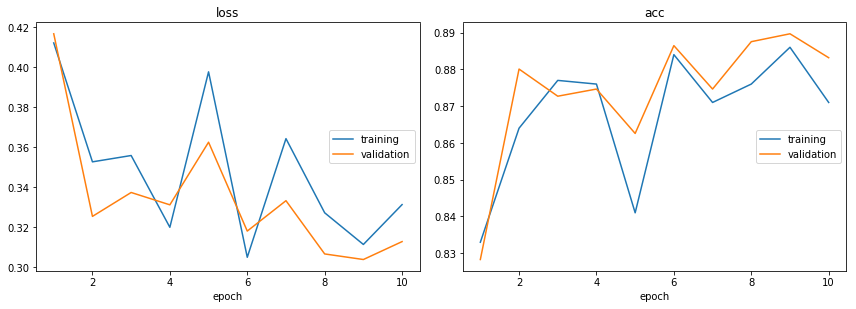

loss:
training   (min:    0.305, max:    0.412, cur:    0.331)
validation (min:    0.304, max:    0.417, cur:    0.313)

acc:
training   (min:    0.833, max:    0.886, cur:    0.871)
validation (min:    0.828, max:    0.890, cur:    0.883)


In [38]:
from livelossplot import PlotLosses

metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []
net.to(DEVICE)

liveloss = PlotLosses()

for epoch in range(N_EPOCHS):
    
    logs = {}
    
    for X, y in train_dl:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        ypred=net(X)
        
        #import pdb
        #pdb.set_trace()
        y = y.unsqueeze(1).float()
        
        loss = criterion(ypred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
    testll, testacc = evaluate_model(net, test_dl)
    trainll, trainacc = evaluate_model(net, train_dl)
    #print("test: {} {}".format(testll, testacc))
    #print("train: {} {}".format(trainll, trainacc))
    metrics.append([trainll, testll, trainacc, testacc])
    logs['val_loss'] = testll
    logs['loss'] = trainll
    logs['val_acc'] = testacc
    logs['acc'] = trainacc
    liveloss.update(logs)
    liveloss.draw()

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 32, sampler = bs, num_workers = 0)
train_dl12 = DataLoader(train_ds, batch_size = 32, sampler = bs, num_workers = 4)
%%timeit
trdl = next(iter(train_dl))

In [48]:
# Error analysis
from sklearn.metrics import confusion_matrix
import pdb

collect_results_ = []
collect_targets_ = []

with torch.no_grad():
    net.eval()
    for batch in test_dl:
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE).detach().cpu().numpy()
        y_pred = net(X)
        collect_results_.append(y_pred.sigmoid().detach().cpu().numpy())
        collect_targets_.append(y)
    #pdb.set_trace()
    preds_proba = np.concatenate(collect_results_)
    targets = np.concatenate(collect_targets_)
    preds = preds_proba >= 0.5
    cnf_matrix = confusion_matrix(targets, preds)
    

In [49]:
cnf_matrix

array([[6467,  591],
       [1151, 6701]])

In [53]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[6467  591]
 [1151 6701]]


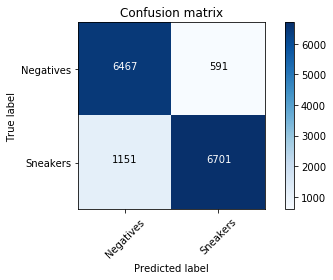

In [54]:
plot_confusion_matrix(cnf_matrix, ['Negatives', 'Sneakers'])